In [1]:
import fsspec

fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

In [ ]:
hrr_hourly_member_files = fs_read.glob('s3://noaa-hrrr-bdp-pds/hrrr.20230722/conus/hrrr.t18z.wrfsfcf*.grib2')

files = sorted(['s3://'+f for f in hrr_hourly_member_files])
print(f'Read {len(files)} HRRR files')

In [ ]:
import re
import datetime

def parse_model_run_datestamp_offset(key: str):
    '''
    Parse the model run forecast time key from the key of the file in the HRRR S3 bucket, given the HRRR naming convention: 
        's3://noaa-hrrr-bdp-pds/hrrr.20230722/conus/hrrr.t12z.wrfsfcf01.grib2' 
    where the model_date is 20230315 and the model_hour is 00 and the offset is 1, this would result in a key of 20230315T01
    '''
    model_date, model_hour, offset = re.search(r'hrrr\.(\d{8})\/conus\/hrrr\.t(\d{2})z\.wrfsfcf(\d{2})', key).groups()
    model_date = datetime.datetime.strptime(f'{model_date}T{model_hour}', '%Y%m%dT%H') + datetime.timedelta(hours=int(offset))
    model_date_key = model_date.strftime('%Y%m%dT%H')
    return model_date_key, int(offset)

In [ ]:
import ujson
from gribberish.kerchunk import scan_gribberish

so = {"anon": True, "use_ssl": False}
json_dir = 'hrrr_hourly/'

def make_json_name(file_url, message_number): #create a unique name for each reference file
    date, _ = parse_model_run_datestamp_offset(file_url)
    name = file_url.split('/')[5].split('.')[0:3]
    return f'{json_dir}{name[0]}_{date}_message{message_number}.json'

def gen_json(file_url):
    out = scan_gribberish(
        file_url, 
        storage_options=so, 
        only_variables=['apcp', 'prate', 'cpofp', 'vis', 'tcdc', 'tmp', 'pres', 'ugrd', 'vgrd', 'dpt'], 
        skip=10,
        filter_by_variable_attrs={
            'ugrd': {
                'statistical_process': '', 
                'fixed_surface_value': '10',
            }, 
            'vgrd': {
                'statistical_process': '', 
                'fixed_surface_value': '10',
            }, 
            'tmp': {
                'fixed_surface_type': 'ground or water surface',
            }, 
            'dpt': {
                'fixed_surface_type': 'specific height level above ground',
                'fixed_surface_value': '2'
            },
            'tcdc': {
                'fixed_surface_value': 'entire atmosphere',
            },
            'pres': {
                'fixed_surface_type': 'ground or water surface',
            }
        }
    )
    for i, message in enumerate(out):
        out_file_name = make_json_name(file_url, i)  # get name
        with fs_write.open(out_file_name, "w") as f: 
            f.write(ujson.dumps(message)) # write to file

In [ ]:
from dask.distributed import Client, progress

client = Client(processes=False)

In [ ]:
futures = client.map(gen_json, files[1:], retries=1)
progress(futures)

In [ ]:
client.shutdown()

In [ ]:
from kerchunk.combine import MultiZarrToZarr

reference_jsons = sorted(fs_write.ls(json_dir)) #get list of file names

print(f'Found {len(reference_jsons)} reference files')

# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(reference_jsons,
                      concat_dims = ['time'],
                      identical_dims=['x', 'y', 'latitude', 'longitude'])

d = mzz.translate()

with open(f'{json_dir}/hrrr_kerchunk.json', 'w') as f:
    f.write(ujson.dumps(d))

In [2]:
import xarray as xr

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo=f'./hrrr_hourly/hrrr_kerchunk_cfgrib.json', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={'time': 1})
ds

<xarray.Dataset>
Dimensions:    (time: 48, y: 1059, x: 1799)
Coordinates:
    latitude   (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
  * time       (time) datetime64[s] 2023-07-22T19:00:00 ... 2023-07-24T18:00:00
  * x          (x) float64 -2.701e+06 -2.698e+06 ... 2.69e+06 2.693e+06
  * y          (y) float64 -1.581e+06 -1.578e+06 ... 1.59e+06 1.593e+06
Data variables:
    apcp       (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    cpofp      (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    dpt        (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    prate      (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    pres       (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    tmp        (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ugrd       (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    vgrd       (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    vis        (time, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    meta:     Generated with gribberishpy

In [3]:
import pyproj
to_xy = pyproj.Transformer.from_crs('epsg:4326', ds.prate.crs, always_xy=True).transform
lat, lng = 41.42717976016072, -71.462122760827
x_sel, y_sel = to_xy(lng, lat)

CPU times: user 2.09 s, sys: 782 ms, total: 2.87 s
Wall time: 2.89 s


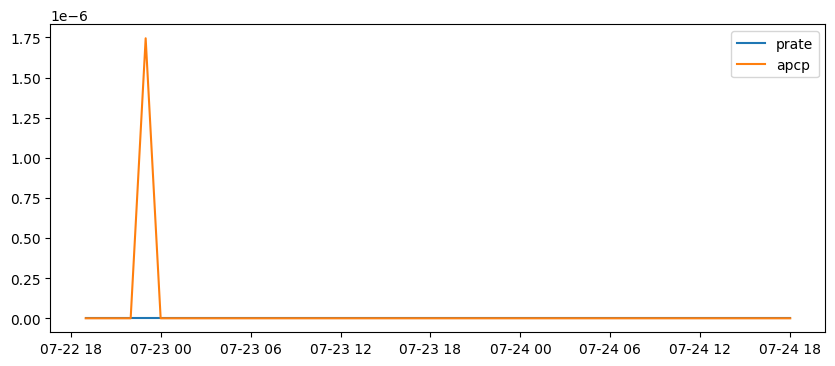

In [5]:
%%time

from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(10, 4))

selected_ds = ds[['prate', 'apcp']].interp(x=x_sel, y=y_sel, method='linear')

selected_prate = (selected_ds.prate * 3600) / 25.4 # convert from kg/m^2/s to in/hr
selected_apcp = (selected_ds.apcp) / 25.4 # convert from kg/m^2/s to in/hr

ax.plot(selected_prate.time, selected_prate, label='prate')
ax.plot(selected_apcp.time, selected_apcp, label='apcp')
ax.legend()

CPU times: user 4.68 s, sys: 1.36 s, total: 6.04 s
Wall time: 10.1 s


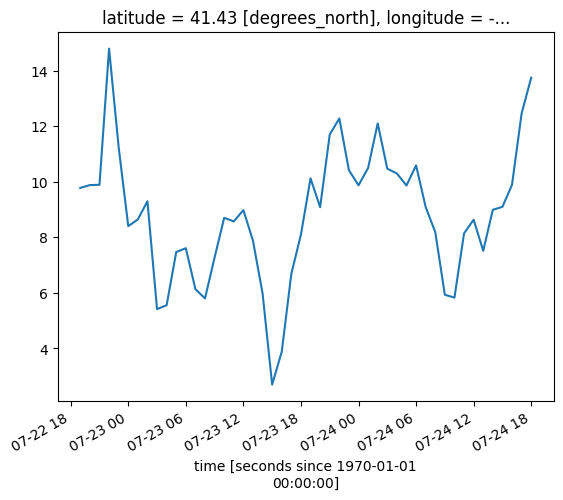

In [7]:
%%time

import numpy as np

ROTCON_P = 0.622515
LON_XX_P = -97.5
LAT_TAN_P = 38.5

angle2 = ROTCON_P*(ds.longitude-LON_XX_P)*0.017453
sinx2 = np.sin(angle2)
cosx2 = np.cos(angle2)

un = cosx2 * ds.ugrd + sinx2 * ds.vgrd
vn = -sinx2 * ds.ugrd + cosx2 * ds.vgrd

wind_speed = np.sqrt(un**2 + vn**2) * 2.23694 # convert from m/s to mph
# wind_dir = (270 - np.arctan2(vn, un) * 180 / np.pi) % 360

wind_speed_ll = wind_speed.interp(x=x_sel, y=y_sel, method='linear')
# wind_dir_ll = wind_dir.interp(x=x_sel, y=y_sel, method='linear').isel(time=2)

wind_speed_ll.plot()